In [108]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
from qutip import *

In [145]:
# functions to calculate parameters

def A(ra, g, gamma):
    return 2 * ra * g**2 / gamma**2

def B(g, gamma, fA):
    return 4 * fA * g**2 / gamma**2

def BdA(g, gamma):
    return 4 * g**2 / gamma**2

def M(n, m, fBdA):
    return 0.5 * (n + m + 2) + (n - m)**2 * fBdA / 8

def N(n, m, fBdA):
    return 0.5 * (n + m + 2) + (n - m)**2 * fBdA / 16

def n_p(fA, fB, kappa):
    return fA * (fA - kappa) / kappa / fB

In [146]:
# parameters

w_c = 2.0 * np.pi
w_a = 2.0 * np.pi
g = 0.1 * 2 * np.pi

gamma = 0.01
kappa = 0.01
ra = 0.01

N_max = 5

fA = A(ra, g, gamma)
fB = B(g, gamma, fA)
fBdA = BdA(g, gamma)
aver_n = n_p(fA, fB, kappa)

In [147]:
fA, fB, kappa

(78.95683520871485, 1246836.3652352307, 0.01)

In [148]:
fB/fA, fBdA

(15791.367041742971, 15791.367041742971)

In [149]:
# average photon number for steady state
aver_n

0.4999366742602235

In [114]:
# coefficients of the differential equation

def fnm(n, m, fA, fBdA, kappa):
    return - (M(n, m, fBdA) * fA / (1 + N(n, m, fBdA) * fBdA)) - 0.5 * kappa * (n + m)

def gnm(n, m, fA, fBdA):
    return np.sqrt(n * m) * fA / (1 + N (n - 1, m - 1, fBdA) * fBdA)

def hnm(n, m, kappa):
    return kappa * np.sqrt((n + 1) * (m + 1))

In [115]:
# parameters in the differential equation
ij = range(N_max)
FNM = np.array([fnm(i, j, fA, fBdA, kappa) for i in ij for j in ij]).reshape(N_max, N_max)
GNM = np.array([gnm(i, j, fA, fBdA) for i in ij for j in ij]).reshape(N_max, N_max)
HNM = np.array([hnm(i, j, kappa) for i in ij for j in ij]).reshape(N_max, N_max)

In [116]:
FNM

array([[-0.00499968, -0.01499241, -0.01999747, -0.02499859, -0.02999905],
       [-0.01499241, -0.01499984, -0.02498737, -0.0299962 , -0.03499803],
       [-0.01999747, -0.02498737, -0.02499989, -0.03498233, -0.03999494],
       [-0.02499859, -0.0299962 , -0.03498233, -0.03499992, -0.04497731],
       [-0.02999905, -0.03499803, -0.03999494, -0.04497731, -0.04499994]])

In [117]:
FNM.reshape(-1)

array([-0.00499968, -0.01499241, -0.01999747, -0.02499859, -0.02999905,
       -0.01499241, -0.01499984, -0.02498737, -0.0299962 , -0.03499803,
       -0.01999747, -0.02498737, -0.02499989, -0.03498233, -0.03999494,
       -0.02499859, -0.0299962 , -0.03498233, -0.03499992, -0.04497731,
       -0.02999905, -0.03499803, -0.03999494, -0.04497731, -0.04499994])

In [118]:
# differential equation
def rho_nm_dot(rho_nm, t):
    rho = rho_nm.reshape(N_max, N_max)
    rho_new = np.zeros([N_max, N_max])
    
    ij = range(N_max)
    for i in ij:
        for j in ij:
            rho_new[i, j] += FNM[i, j] * rho[i, j]
            if i > 0 and j > 0:
                rho_new[i, j] += GNM[i, j] * rho[i - 1, j - 1]
            if i < N_max - 1 and j < N_max - 1:
                rho_new[i, j] += HNM[i, j] * rho[i + 1, j + 1]
    
    return rho_new.reshape(-1)

In [134]:
t_list = np.linspace(0, 200, 801)
rho_0 = np.zeros(N_max * N_max)
rho_0[0] = 1

In [135]:
rho_0

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [136]:
result = odeint(rho_nm_dot, rho_0, t_list)

In [137]:
len(result)

801

In [138]:
result[100].reshape(N_max, N_max)

array([[  8.95303410e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.90137585e-02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.47527986e-03,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.01839999e-04,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   5.55773695e-06]])

In [139]:
Qobj(result[100].reshape(N_max, N_max))

Quantum object: dims = [[5], [5]], shape = [5, 5], type = oper, isherm = True
Qobj data =
[[  8.95303410e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   9.90137585e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   5.47527986e-03   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.01839999e-04
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    5.55773695e-06]]

In [140]:
# ordinary differential equation for the diagonal terms

def pn_dot(pn, t):
    pn_new = np.zeros(N_max)
    for n in xrange(N_max):
        pn_new[n] += (- (n + 1) * fA / (1 + (n + 1) * fBdA)  - kappa * n) * pn[n]
        if n > 0:
            pn_new[n] += n * fA / (1 + n * fBdA) * pn[n-1]
        if n < N_max - 1:
            pn_new[n] += kappa * (n+1) * pn[n + 1]
    return pn_new

### initial state: fock

In [186]:
t_list = np.linspace(0, 400, 3201)
pn_0 = np.zeros(N_max)
pn_0[0] = 1

In [187]:
result2 = odeint(pn_dot, pn_0, t_list)

In [188]:
result2[100]

array([  9.42944526e-01,   5.53958873e-02,   1.62724506e-03,
         3.18682430e-05,   4.67331682e-07])

In [189]:
aver_n = []
for vec in result2:
    n = sum(vec * range(N_max))
    aver_n.append(n)

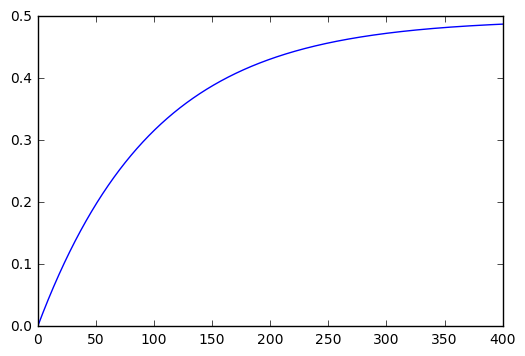

In [190]:
plt.plot(t_list, aver_n)
plt.show()

### initial state: coherent

In [191]:
t_list = np.linspace(0, 400, 3201)
rho_0 = coherent_dm(N_max, 0.5)
rho_0 = np.real(coo_matrix(rho_0.data).toarray().reshape(-1))

In [192]:
result3 = odeint(rho_nm_dot, rho_0, t_list)

In [ ]:
aver_n = []
for vec in result3:
    n = sum(vec * range(N_max))
    aver_n.append(n)